https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2023/06-best-practices/homework.md

In this homework, we'll take the ride duration prediction model
that we deployed in batch mode in homework 4 and improve the 
reliability of our code with unit and integration tests. 

## Q1. Refactoring

Before we can start converting our code with tests, we need to 
refactor it. We'll start by getting rid of all the global variables. 

* Let's create a function `main` with two parameters: `year` and
`month`.
* Move all the code (except `read_data`) inside `main`
* Make `categorical` a parameter for `read_data` and pass it inside `main`

Now we need to create the "main" block from which we'll invoke
the main function. How does the `if` statement that we use for
this looks like? 


Hint: after refactoring, check that the code still works. Just run
it e.g. for Feb 2022 and see if it finishes successfully. 

To make it easier to run it, you can write results to your local
filesystem. E.g. here:

```python
output_file = f'taxi_type=yellow_year={year:04d}_month={month:02d}.parquet'
```

Answer: `if __name__ == '__main__':`

## Q2. Installing pytest

Now we need to install `pytest`:

```bash
pipenv install --dev pytest
```

Next, create a folder `tests` and then two files inside. 

The first one will be the file with tests. We can name it `test_batch.py`. 

The second file will be `__init__.py`. So, why do we need this second file?

- To define a package and specify its boundaries
- To manage the import of modules from the package 
- Both of the above options are correct
- To initialize a new object

Answer: __To define a package and specify its boundaries__

## Q3. Writing first unit test

Now let's cover our code with unit tests.

We'll start with the pre-processing logic inside `read_data`.

It's difficult to test right now because first reads
the file and then performs some transformations. We need to split this 
code into two parts: reading (I/O) and transformation. 

So let's create a function `prepare_data` that takes in a dataframe 
(and some other parameters too) and applies some transformation to it.

(That's basically the entire `read_data` function after reading 
the parquet file)

Now create a test and use this as input:

```python
data = [
    (None, None, dt(1, 2), dt(1, 10)),
    (1, None, dt(1, 2), dt(1, 10)),
    (1, 2, dt(2, 2), dt(2, 3)),
    (None, 1, dt(1, 2, 0), dt(1, 2, 50)),
    (2, 3, dt(1, 2, 0), dt(1, 2, 59)),
    (3, 4, dt(1, 2, 0), dt(2, 2, 1)),     
]

columns = ['PULocationID', 'DOLocationID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']
df = pd.DataFrame(data, columns=columns)
```

Where `dt` is a helper function:

```python
from datetime import datetime

def dt(hour, minute, second=0):
    return datetime(2022, 1, 1, hour, minute, second)
```

Define the expected output and use the assert to make sure 
that the actual dataframe matches the expected one

Tip: When you compare two Pandas DataFrames, the result is also a DataFrame.
The same is true for Pandas Series. Also, a DataFrame could be turned into a
list of dictionaries.  

How many rows should be there in the expected dataframe?

- 1
- 2
- 3
- 4

Answer: __3__

## Q4. Mocking S3 with Localstack 

Now let's prepare for an integration test. In our script, we 
write data to S3. So we'll use Localstack to mimic S3.

First, let's run Localstack with Docker compose. Let's create a 
`docker-compose.yaml` file with just one service: localstack. Inside
localstack, we're only interested in running S3. 

Start the service and test it by creating a bucket where we'll
keep the output. Let's call it "nyc-duration".

With AWS CLI, this is how we create a bucket:

```bash
aws s3 mb s3://nyc-duration
```

Then we need to check that the bucket was successfully created. With AWS, this is how we typically do it:

```bash
aws s3 ls
```

In both cases we should adjust commands for localstack. Which option do we need to use for such purposes?

- `--endpoint-url`
- `--profile`
- `--region`
- `--version`

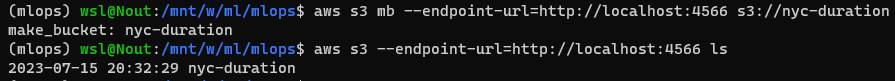

`aws s3 mb --endpoint-url=http://localhost:4566 s3://nyc-duration`
<br>`aws s3 --endpoint-url=http://localhost:4566 ls`

Answer: __--endpoint-url__

## Make input and output paths configurable

Right now the input and output paths are hardcoded, but we want
to change it for the tests. 

One of the possible ways would be to specify `INPUT_FILE_PATTERN` and `OUTPUT_FILE_PATTERN` via the env 
variables. Let's do that:


```bash
export INPUT_FILE_PATTERN="s3://nyc-duration/in/{year:04d}-{month:02d}.parquet"
export OUTPUT_FILE_PATTERN="s3://nyc-duration/out/{year:04d}-{month:02d}.parquet"
```

And this is how we can read them:

```python
def get_input_path(year, month):
    default_input_pattern = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year:04d}-{month:02d}.parquet'
    input_pattern = os.getenv('INPUT_FILE_PATTERN', default_input_pattern)
    return input_pattern.format(year=year, month=month)


def get_output_path(year, month):
    default_output_pattern = 's3://nyc-duration-prediction-alexey/taxi_type=fhv/year={year:04d}/month={month:02d}/predictions.parquet'
    output_pattern = os.getenv('OUTPUT_FILE_PATTERN', default_output_pattern)
    return output_pattern.format(year=year, month=month)


def main(year, month):
    input_file = get_input_path(year, month)
    output_file = get_output_path(year, month)
    # rest of the main function ... 
```

## Reading from Localstack S3 with Pandas

So far we've been reading parquet files from S3 with using
pandas `read_parquet`. But this way we read it from the
actual S3 service. Now we need to replace it with our localstack
one.

For that, we need to specify the endpoint url:

```python
options = {
    'client_kwargs': {
        'endpoint_url': S3_ENDPOINT_URL
    }
}

df = pd.read_parquet('s3://bucket/file.parquet', storage_options=options)
```

Let's modify our `read_data` function:

- check if `S3_ENDPOINT_URL` is set, and if it is, use it for reading
- otherwise use the usual way

## Q5. Creating test data

Now let's create `integration_test.py`

We'll use the dataframe we created in Q3 (the dataframe for the unit test)
and save it to S3. You don't need to do anything else: just create a dataframe 
and save it.

We will pretend that this is data for January 2022.

Run the `integration_test.py` script. After that, use AWS CLI to verify that the 
file was created. 

Use this snipped for saving the file:

```python
df_input.to_parquet(
    input_file,
    engine='pyarrow',
    compression=None,
    index=False,
    storage_options=options
)
```

What's the size of the file?

- 3667
- 23667
- 43667
- 63667

Note: it's important to use the code from the snippet for saving
the file. Otherwise the size may be different depending on the OS,
engine and compression. Even if you use this exact snippet, the size
of your dataframe may still be a bit off. Just select the closest option.

In [2]:
!aws s3 --endpoint-url=http://localhost:4566 ls nyc-duration

                           PRE in/
2023-07-15 21:09:33       3667 input.parquet


Answer: __3667__

## Q6. Finish the integration test

We can read from our localstack s3, but we also need to write to it.

Create a function `save_data` which works similarly to `read_data`,
but we use it for saving a dataframe. 

Let's run the `batch.py` script for "January 2022" (the fake data
we created in Q5). 

We can do that from our integration test in Python: we can use
`os.system` for doing that (there are other options too). 

Now it saves the result to localstack.

The only thing we need to do now is to read this data and 
verify the result is correct. 

What's the sum of predicted durations for the test dataframe?

- 10.50
- 31.51
- 59.28
- 81.22

In [7]:
import os 
import pandas as pd

S3_ENDPOINT_URL = 'http://localhost:4566'
options = {
    'client_kwargs': {
        'endpoint_url': S3_ENDPOINT_URL
    }
}
df = pd.read_parquet('s3://nyc-duration/out/2022-01.parquet', storage_options=options)
df.head()

,ride_id,predicted_duration
0,2022/01_0,24.781802
1,2022/01_1,0.617543
2,2022/01_2,6.108105


In [8]:
df.predicted_duration.sum()

31.507450372727607

Answer: __31.51__